In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW
import torch.nn.functional as F

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm


# CONFIGS
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Settings
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 4

TEXT_COL = 'text'
TARGET_COL = 'status'


In [2]:

# Load the dataset
DATA_PATH = 'D:\\Mental-Health-Classification\\data\\mental_heath_unbanlanced.csv'
data = pd.read_csv(DATA_PATH)


# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())


# Validate your dataset has the required columns before proceeding
assert TEXT_COL in data.columns, f"{TEXT_COL} not in columns: {data.columns}" 
assert TARGET_COL in data.columns, f"{TARGET_COL} not in columns: {data.columns}"


First few rows of the dataset:
   Unique_ID                                               text   status
0        0.0                                         oh my gosh  Anxiety
1        1.0  trouble sleeping, confused mind, restless hear...  Anxiety
2        2.0  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3        3.0  I've shifted my focus to something else but I'...  Anxiety
4        4.0  I'm restless and restless, it's been a month n...  Anxiety


In [3]:
# Data Balance Check
X = data[TEXT_COL].values
y = data[TARGET_COL]
print("\nClass distribution in the dataset:")
print(data[TARGET_COL].value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Compute Class Weights
classes = np.unique(y_train_encoded)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_encoded)

class_weights = torch.tensor(
    class_weights_array,
    dtype=torch.float
    ).to(device)

print("\nClass weights (to handle imbalance):")
for idx, weight in enumerate(class_weights_array):
    class_name = label_encoder.classes_[idx]
    count = np.sum(y_train_encoded == idx)
    print(f"  {class_name:12s}: weight={weight:.4f}, count={count:,}")


Class distribution in the dataset:
status
Normal        18391
Depression    14506
Suicidal      11212
Anxiety        5503
Name: count, dtype: int64

Class weights (to handle imbalance):
  Anxiety     : weight=2.2540, count=4,402
  Depression  : weight=0.8550, count=11,605
  Normal      : weight=0.6744, count=14,713
  Suicidal    : weight=1.1063, count=8,969


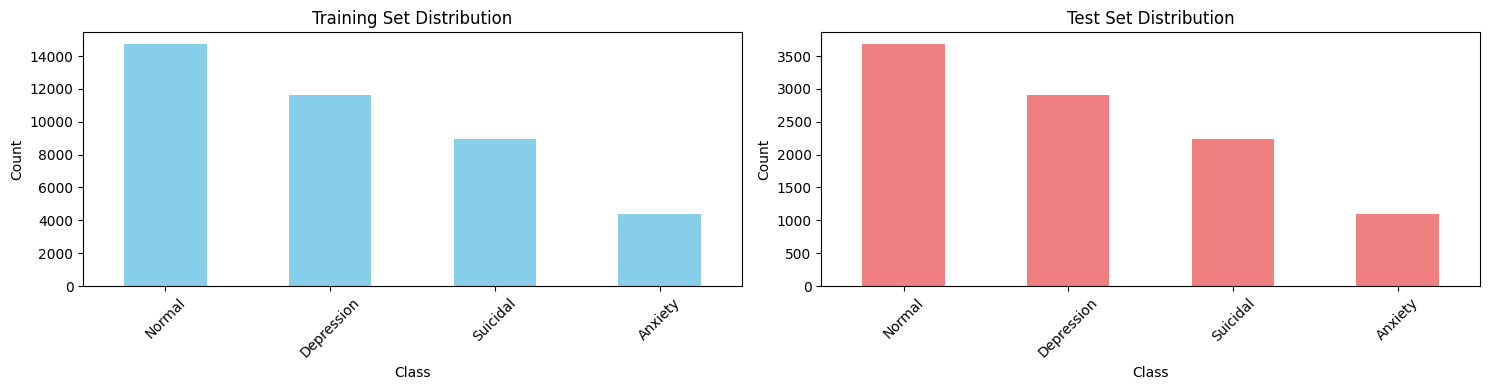

In [4]:
# Visualize The Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

pd.Series(y_test).value_counts().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Test Set Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
# Create PyTorch Dataset
class MentalHealthDataset(Dataset):
    def __init__(self, texts,labels,tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self,idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(), # Transform 2D Shape to 1D
            'attention_mask': encoding['attention_mask'].flatten(), # Ignore the padding Tokens
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [6]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

train_dataset_tesor = MentalHealthDataset(
    texts=X_train,
    labels=y_train_encoded,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

test_dataset_tesor = MentalHealthDataset(
    texts=X_test,
    labels=y_test_encoded,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# Data Loader
train_loader = DataLoader(
    train_dataset_tesor,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset_tesor,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

  Batch size: 16
  Training batches: 2481
  Test batches: 621


In [7]:
# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_encoder.classes_)
)

# Move model to GPU/CPU
model.to(device)
print(f"Model loaded: {MODEL_NAME}")
print(f"Number of labels: {len(label_encoder.classes_)}")
print(f"Model moved to: {device}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: distilbert-base-uncased
Number of labels: 4
Model moved to: cuda


In [ ]:
# Optimizers and Loss Function  

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

class FocalLoss(nn.Module): # Focal Loss for Imbalance Data
    
    def __init__(self, alpha=None, gamma = 2.0, reduction='mean'):
        super(FocalLoss).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction = 'none', weight = self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)

def train_epochs(model, data_loader, optimizer, loss_fn, device):
    
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # Progression 
    progress_bar = tqdm(data_loader, desc='Training') # Create a progress bar for training
    
    for batch in progress_bar:
        
        # Get data from batch and move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward Pass
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask, 
        )
        
        logits = output.logits
        
        # Loss Calculation
        loss = loss_fn(logits, labels)
        
        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accuracy
        pred = torch.argmax(logits, dim=1)
        correct_predictions = correct_predictions + (pred == labels).sum().item()
        total_samples = total_samples + labels.size(0)
        total_loss = total_loss + loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}", 
                                  'accuracy': f'{correct_predictions/total_samples:.4f}'})
        
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

IndentationError: expected an indented block after function definition on line 5 (2874712882.py, line 10)

In [9]:
# Evaluation Step

def eval_model(model, data_loader, loss_fn, device):
    # Model Evaluation
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    
    # No Gradient Calculation
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
           # Get Data 
           input_ids = batch['input_ids'].to(device)
           attention_mask = batch['attention_mask'].to(device)
           labels = batch['labels'].to(device)
           
           # Forward Pass
           output = model(
                input_ids=input_ids,
                attention_mask=attention_mask, 
            )
           
           logits = output.logits
           
           # Calculate Loss
           loss = loss_fn(logits, labels)
           total_loss = total_loss + loss.item()
           
           # Prediction 
           prediction = torch.argmax(logits, dim=1)
           correct_predictions = correct_predictions + (prediction == labels).sum().item()
           total_samples = total_samples + labels.size(0)
           
           # Save predictions and label 
           all_predictions.extend(prediction.cpu().numpy())
           all_labels.extend(labels.cpu().numpy())
    
    # Average Loss and Accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy, all_predictions, all_labels

In [ ]:
# Training Loop

model_history = {
    'train_loss': [],
    'train_accuracy': []
}

best_accuracy = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")
    
    train_loss, train_acc = train_epochs(
        model=model,
        data_loader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device
    )

    # Print results
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    
    # Save the history
    model_history['train_loss'].append(train_loss)
    model_history['train_accuracy'].append(train_acc)
    
    # Save Best Model
    if train_acc > best_accuracy:
        best_accuracy = train_acc
        torch.save(model.state_dict(), 'model(1.1).pt')
        print("  Best model saved. (Acc: {train_acc:.4f})")
        
print(f"\n{'='*50}")
print("TRAINING COMPLETED!")
print(f"{'='*50}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Epoch 1/2


Training: 100%|██████████| 2481/2481 [02:20<00:00, 17.64it/s, loss=0.7435, accuracy=0.7844]



Epoch 1 Results:
Train Loss: 0.5238, Train Acc: 0.7844
  Best model saved. (Acc: {train_acc:.4f})

Epoch 2/2


Training: 100%|██████████| 2481/2481 [02:18<00:00, 17.87it/s, loss=0.4951, accuracy=0.8518]



Epoch 2 Results:
Train Loss: 0.3606, Train Acc: 0.8518
  Best model saved. (Acc: {train_acc:.4f})

TRAINING COMPLETED!
Best Validation Accuracy: 0.8518


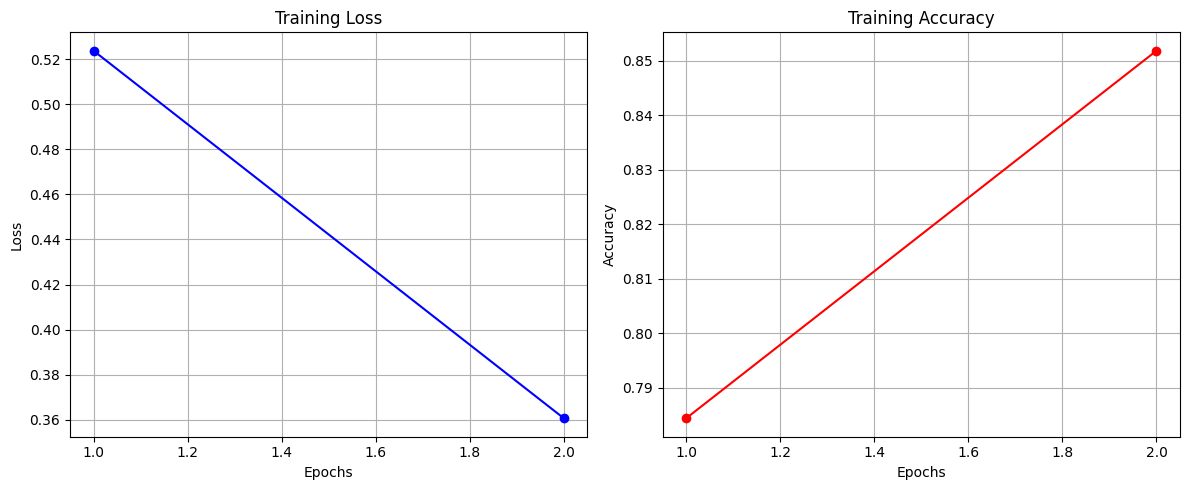

In [11]:
fig , axes = plt.subplots(1,2, figsize=(12,5))

epochs_range = range(1, EPOCHS + 1)

# Plot Loss
axes[0].plot(epochs_range, model_history['train_loss'], 'bo-', label='Training Loss')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(epochs_range, model_history['train_accuracy'], 'ro-', label='Training Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Evaluation on Test Set

print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc, test_pred, test_labels = eval_model(
    model = model,
    data_loader = test_loader,
    loss_fn = loss_fn,
    device = device
)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")



FINAL EVALUATION ON TEST SET


Evaluating: 100%|██████████| 621/621 [00:14<00:00, 42.26it/s]


Test Results:
  Test Loss: 0.4268
  Test Accuracy: 0.8245



CLASSIFICATION REPORT

              precision    recall  f1-score   support

     Anxiety     0.7337    0.9210    0.8168      1101
  Depression     0.7612    0.7394    0.7501      2901
      Normal     0.9776    0.8888    0.9311      3678
    Suicidal     0.7373    0.7820    0.7590      2243

    accuracy                         0.8245      9923
   macro avg     0.8024    0.8328    0.8142      9923
weighted avg     0.8329    0.8245    0.8266      9923


CONFUSION MATRIX

[[1014   72    4   11]
 [ 157 2145   29  570]
 [ 188  177 3269   44]
 [  23  424   42 1754]]


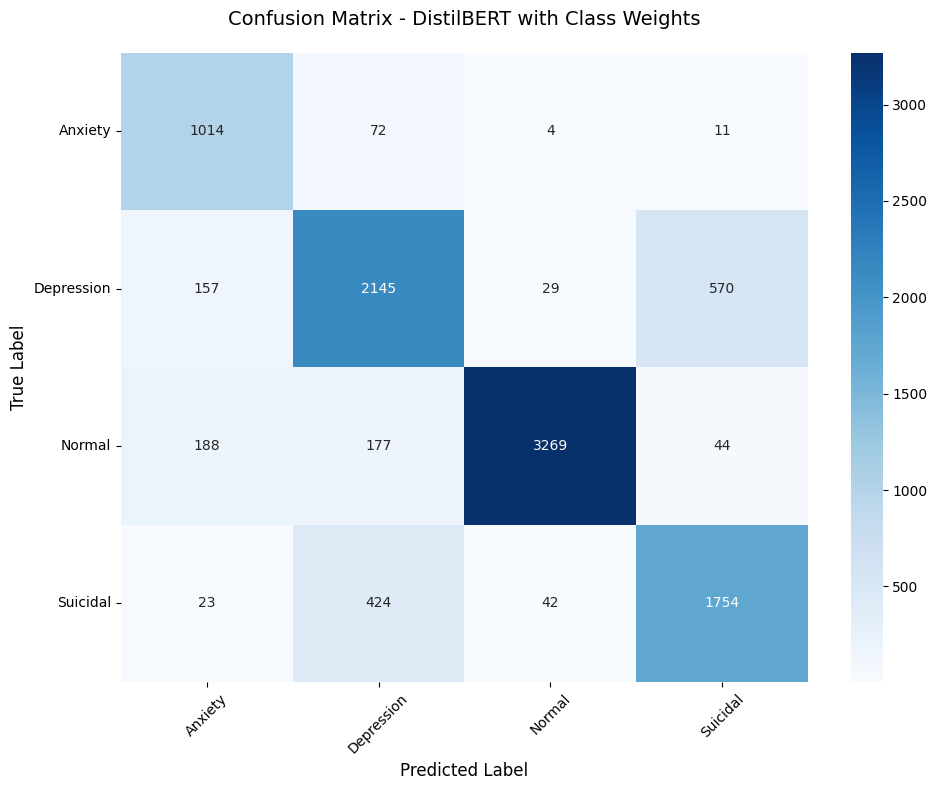


PER-CLASS ACCURACY

Anxiety     : 92.10%
Depression  : 73.94%
Normal      : 88.88%
Suicidal    : 78.20%


In [13]:
# Classification and Confusion Matrix

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print()

report = classification_report(
    test_labels, 
    test_pred,
    target_names=label_encoder.classes_,
    digits=4
)
print(report)

print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(test_labels, test_pred)
print()
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix - DistilBERT with Class Weights', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n" + "="*50)
print("PER-CLASS ACCURACY")
print("="*50)
print()

for i, class_name in enumerate(label_encoder.classes_):
    class_accuracy = cm[i, i] / cm[i].sum() * 100
    print(f"{class_name:12s}: {class_accuracy:.2f}%")